In [192]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor


import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so # Necessário seaborn 0.12.1 ou maior
from matplotlib import style

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error


# Conectar ao MetaTrader 5
mt5.initialize()

# Definir o símbolo e o período
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_M5

# Obter os dados dos últimos 160 períodos
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, 160)

# Converter os dados para um dataframe
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

In [193]:
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2023-06-02 15:45:00,1.07478,1.07508,1.07440,1.07450,573,0,0
2023-06-02 15:50:00,1.07450,1.07452,1.07364,1.07446,566,0,0
2023-06-02 15:55:00,1.07442,1.07480,1.07420,1.07474,387,0,0
2023-06-02 16:00:00,1.07480,1.07578,1.07458,1.07552,471,0,0
2023-06-02 16:05:00,1.07556,1.07632,1.07540,1.07581,392,0,0
...,...,...,...,...,...,...,...
2023-06-05 04:40:00,1.06950,1.06984,1.06945,1.06970,172,0,0
2023-06-05 04:45:00,1.06970,1.07004,1.06969,1.06994,272,0,0
2023-06-05 04:50:00,1.06994,1.07006,1.06982,1.06992,148,0,0


In [194]:
# Preparar os dados para treinamento
X = df.drop(['close'], axis=1)
y = df['close']

In [195]:
X

,open,high,low,tick_volume,spread,real_volume
time,,,,,,
2023-06-02 15:45:00,1.07478,1.07508,1.07440,573,0,0
2023-06-02 15:50:00,1.07450,1.07452,1.07364,566,0,0
2023-06-02 15:55:00,1.07442,1.07480,1.07420,387,0,0
2023-06-02 16:00:00,1.07480,1.07578,1.07458,471,0,0
2023-06-02 16:05:00,1.07556,1.07632,1.07540,392,0,0
...,...,...,...,...,...,...
2023-06-05 04:40:00,1.06950,1.06984,1.06945,172,0,0
2023-06-05 04:45:00,1.06970,1.07004,1.06969,272,0,0
2023-06-05 04:50:00,1.06994,1.07006,1.06982,148,0,0


In [196]:
y

time
2023-06-02 15:45:00    1.07450
2023-06-02 15:50:00    1.07446
2023-06-02 15:55:00    1.07474
2023-06-02 16:00:00    1.07552
2023-06-02 16:05:00    1.07581
                        ...   
2023-06-05 04:40:00    1.06970
2023-06-05 04:45:00    1.06994
2023-06-05 04:50:00    1.06992
2023-06-05 04:55:00    1.07014
2023-06-05 05:00:00    1.07014
Name: close, Length: 160, dtype: float64

In [197]:
from sklearn.preprocessing import MinMaxScaler

In [198]:
# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [199]:
# transforma os dados em um Data Frame
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [200]:
# Processamento dos dados com Min Max Scaler
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit(X_train).transform(X_train))
y_train = pd.DataFrame(scaler.fit(y_train).transform(y_train))

X_test = pd.DataFrame(scaler.fit(X_test).transform(X_test))
y_test = pd.DataFrame(scaler.fit(y_test).transform(y_test))

In [201]:
# Grid search custom para encontrar o modelo mais ajustado com os parâmetros padrões
def grid_search_regression_models(X_train, X_test, y_train, y_test):

  # Data frame com os resultados obtidos de cada modelo
  resultados = pd.DataFrame(index=['MAE', 'RMSE', 'MAPE', 'R2'])
  # Dicionário com os algoritmos de regressão
  algoritmos = {'Suport Vector Machine Regression(SVM-SVR)':SVR(),
                'K-Neighbors Regressor' : KNeighborsRegressor(),
                'CatBoost Regressor': CatBoostRegressor(verbose = False, n_estimators=1000),
                'XGBoost Regressor': XGBRegressor(verbose = False, n_estimators=1000),
                'LightGBM Regressor': LGBMRegressor(verbose = -1, n_estimators=1000)}

  # Loop que percorre cada modelo, treina, treina, e avalia.
  for nome, alg in algoritmos.items():
    # Treina e prediz o modelo
    model = alg.fit(X_train, y_train).predict(X_test)
    # Metricas de avaliação
    MAE = np.round(mean_absolute_error(y_test, model), 2)
    RMSE = np.round(np.sqrt(mean_squared_error(y_test, model)), 2)
    MAPE = np.round(mean_absolute_percentage_error(y_test, model), 2)
    R2 = np.round(r2_score(y_test, model), 2)
    # Adiciona o resultado no data frame de resultados
    resultados[nome] = [MAE, RMSE, MAPE, R2]
  # Retorna o resultado final
  return(resultados.T.sort_values(by='MAPE'))

In [202]:
# Mostra o resultado dos algorítimos
grid_search_regression_models(X_train, X_test, y_train, y_test)

C:\Users\domka\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[22:00:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



,MAE,RMSE,MAPE,R2
XGBoost Regressor,0.06,0.07,1.044224e+13,0.94
CatBoost Regressor,0.10,0.14,1.113673e+13,0.78
K-Neighbors Regressor,0.07,0.09,1.385104e+13,0.91
LightGBM Regressor,0.09,0.12,1.454614e+13,0.82
Suport Vector Machine Regression(SVM-SVR),0.11,0.15,1.556413e+13,0.75


In [203]:
# Instancía o modelo para a variável
model = XGBRegressor()

# Treina o modelo com o algorítimo vencedor 
model.fit(X_train, y_train)

# Faz a predição com os dados de teste
y_pred = pd.DataFrame(model.predict(X_test))

In [204]:
# Retorna os valores na escala original
y_pred = pd.DataFrame(scaler.inverse_transform(y_pred))
y_test = pd.DataFrame(scaler.inverse_transform(y_test))
y_pred.columns = ['prediction']
y_test.columns = ['target']

In [205]:
y_pred.head()

,prediction
0,1.070644
1,1.070492
2,1.070647
3,1.070643
4,1.070698


In [206]:
y_test.tail()

,target
43,1.06970
44,1.06994
45,1.06992
46,1.07014
47,1.07014


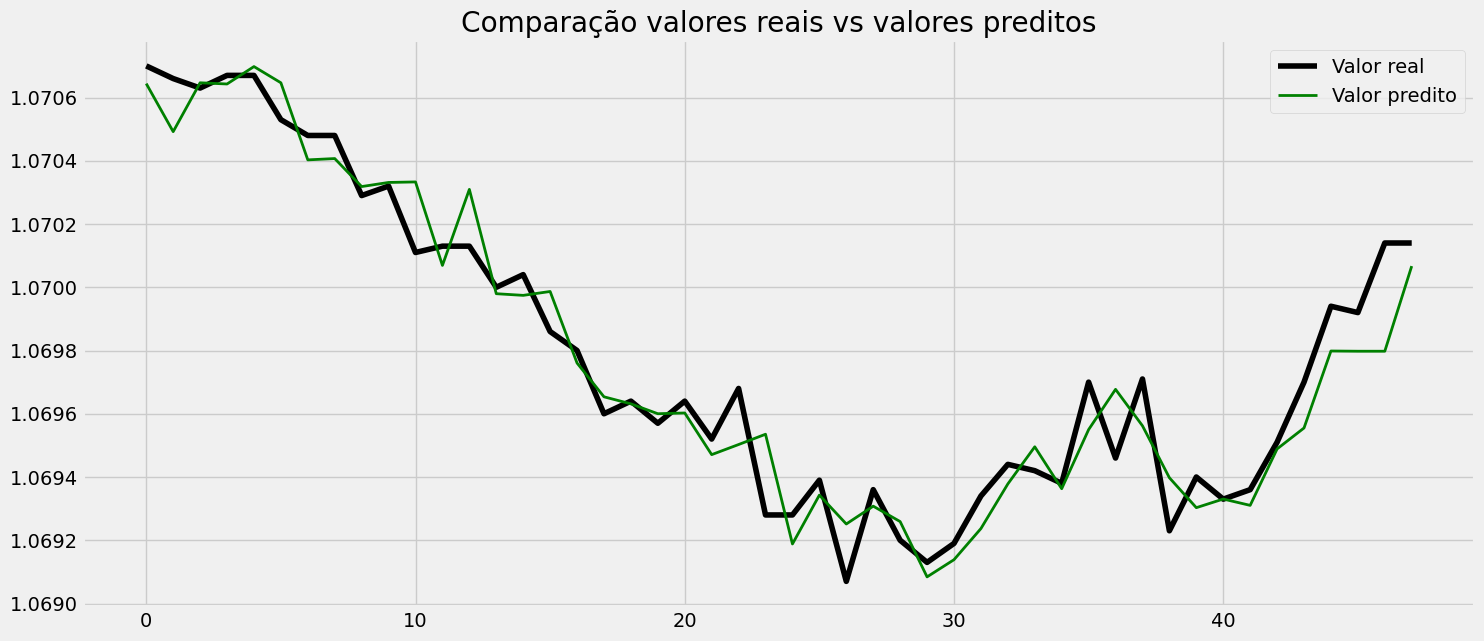

In [207]:
# Faz um único DataFrame com os dados de validação e os dados previstos pelo modelo
y_validation = pd.DataFrame(y_test)
y_validation['prediction'] = y_pred

# Estilo do gráfico
plt.style.use('fivethirtyeight')

# configuração do gráfico
fig, ax = plt.subplots()
# Linha dos valores reais e legenda
ax = sns.lineplot(x = y_validation.index, y = y_validation['target'], color = 'black', label='Valor real', lw=4)
# linha dos valores previstos e legenda
ax = sns.lineplot(x = y_validation.index, y = y_validation['prediction'], color = 'green',label='Valor predito', lw=2)
# Titulo do eixo x
ax.set_xlabel('')
# Titulo do eixo y
ax.set_ylabel('Valor')
# Titulo principal
ax.set_title('Comparação valores reais vs valores preditos')
# Tamanho do gráfico
fig.set_size_inches(16,7)

In [208]:
# Fecha o serviço do MT5
mt5.shutdown()

True